# <center>CodeClause - Data Science Internship</center>
## <center>Project - Brain Tumor Detection with Data Science</center>


# Project Description
### There are many famous deep learning projects on MRI scan dataset. One of them is Brain Tumor Detection. You can use transfer learning on these MRI scans to get the required features for classification. Or you can train your own convolution neural network from scratch to detect brain tumors.

#### Click here to download Dataset
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [5]:
image_dir = Path('C:/Users/PRIYANK GOSWAMI/Desktop/Internships/CodeClause/Brain_Tumor_Detection/Training')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df_train = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df_train[image_df_train['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Shuffle the DataFrame and reset index
image_df_train = image_df_train.sample(frac=1).reset_index(drop = True)

# Show the result
display(image_df_train.head())
print(image_df_train.shape)
print(image_df_train['Labels'].value_counts())

,Filepaths,Labels
0,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,meningioma_tumor
1,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,glioma_tumor
2,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,pituitary_tumor
3,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,glioma_tumor
4,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,pituitary_tumor


(2870, 2)
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: Labels, dtype: int64


In [6]:
# Do the same for testset and merge both dataframes
image_dir = Path('C:/Users/PRIYANK GOSWAMI/Desktop/Internships/CodeClause/Brain_Tumor_Detection/Testing')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

image_df_test = pd.concat([filepaths, labels], axis=1)
image_df_test = image_df_test[image_df_test['Labels'].apply(lambda x: x[-2:] != 'GT')]

image_df_test = image_df_test.sample(frac=1).reset_index(drop = True)
display(image_df_test.head())
print(image_df_test.shape)
print(image_df_test['Labels'].value_counts())

,Filepaths,Labels
0,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,meningioma_tumor
1,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,meningioma_tumor
2,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,pituitary_tumor
3,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,glioma_tumor
4,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,meningioma_tumor


(394, 2)
meningioma_tumor    115
no_tumor            105
glioma_tumor        100
pituitary_tumor      74
Name: Labels, dtype: int64


In [7]:
# merge both dataframes
df = pd.concat([image_df_train, image_df_test], axis=0)
df = df.reset_index(drop = True)
display(df.head())
print(df.shape)
print(df['Labels'].value_counts())

,Filepaths,Labels
0,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,meningioma_tumor
1,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,glioma_tumor
2,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,pituitary_tumor
3,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,glioma_tumor
4,C:\Users\PRIYANK GOSWAMI\Desktop\Internships\C...,pituitary_tumor


(3264, 2)
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: Labels, dtype: int64


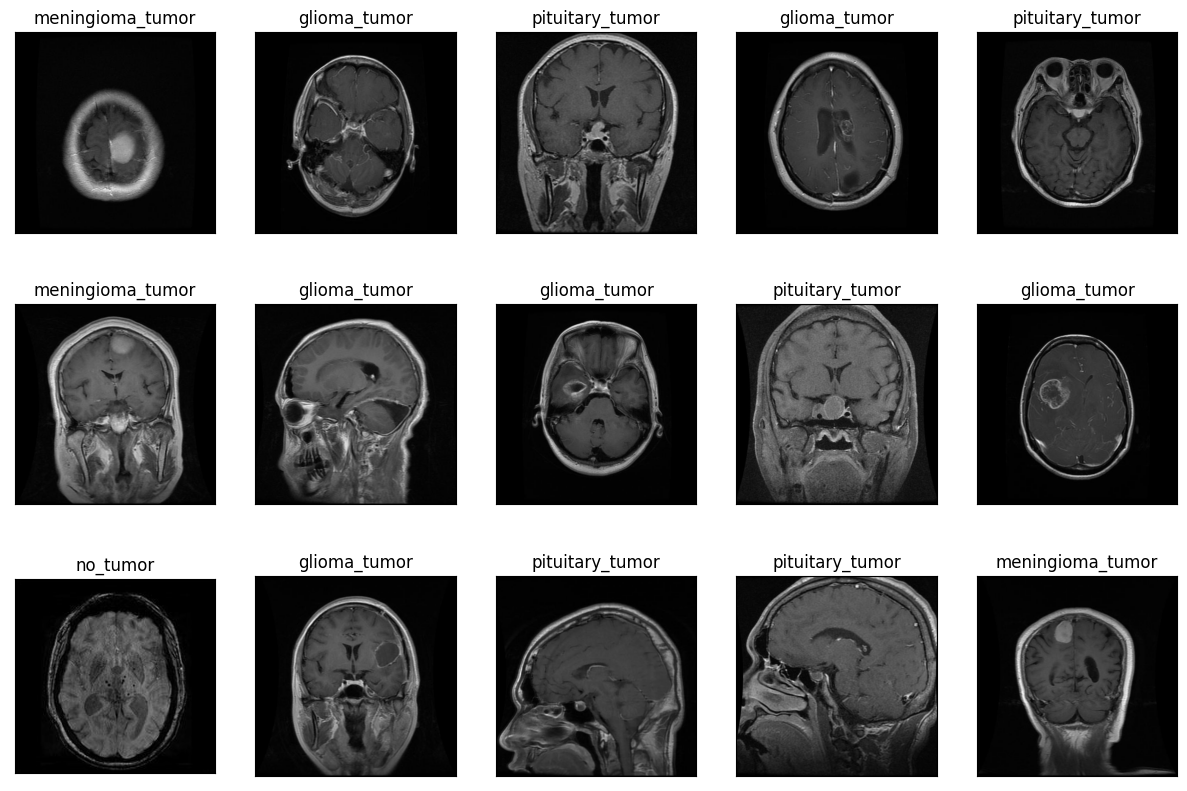

In [8]:
#Displaying a subsample of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepaths[i]))
    ax.set_title(df.Labels[i])
plt.show()

In [9]:
import tensorflow as tf

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(df, train_size=0.85, shuffle=True, random_state=1)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 2358 validated image filenames belonging to 4 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 416 validated image filenames belonging to 4 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=False
)

Found 490 validated image filenames belonging to 4 classes.


In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [16]:
input_shape = (512, 512, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (5,5)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 508, 508, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 101, 101, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 99, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 8)        0

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_images, validation_data=val_images, epochs=6, callbacks=callback)

Epoch 1/6
590/590 [==============================] - 172s 285ms/step - loss: 1.1235 - accuracy: 0.5089 - val_loss: 0.7265 - val_accuracy: 0.6635
Epoch 2/6
590/590 [==============================] - 171s 290ms/step - loss: 0.8135 - accuracy: 0.6595 - val_loss: 0.5965 - val_accuracy: 0.7957
Epoch 3/6
590/590 [==============================] - 166s 281ms/step - loss: 0.6221 - accuracy: 0.7561 - val_loss: 0.4709 - val_accuracy: 0.8197
Epoch 4/6
590/590 [==============================] - 166s 282ms/step - loss: 0.4728 - accuracy: 0.8109 - val_loss: 0.5093 - val_accuracy: 0.8125
Epoch 5/6
590/590 [==============================] - 161s 272ms/step - loss: 0.3397 - accuracy: 0.8728 - val_loss: 0.3846 - val_accuracy: 0.8654
Epoch 6/6
590/590 [==============================] - 169s 286ms/step - loss: 0.2534 - accuracy: 0.9071 - val_loss: 0.3794 - val_accuracy: 0.8438


In [19]:
model.save('2nd-model.h5')

1/1 [==============================] - 3s 3s/step
(1, 101, 101, 8)
(1, 99, 99, 8)
(1, 33, 33, 8)
(1, 31, 31, 8)
(1, 15, 15, 8)
(1, 1800)
(1, 128)
(1, 128)
(1, 64)
(1, 64)
(1, 32)
(1, 32)
(1, 4)


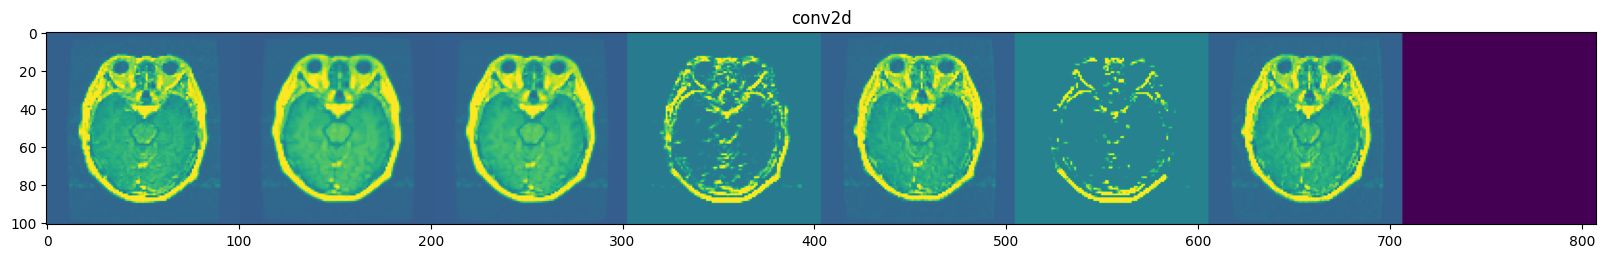

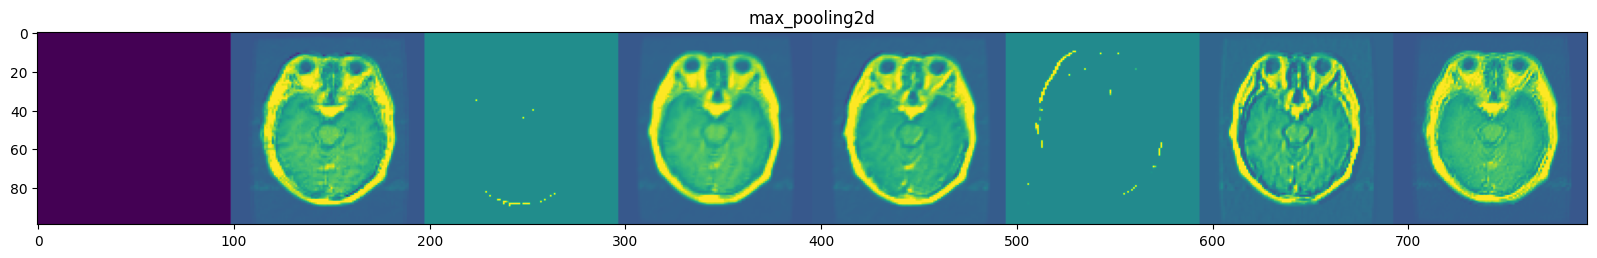

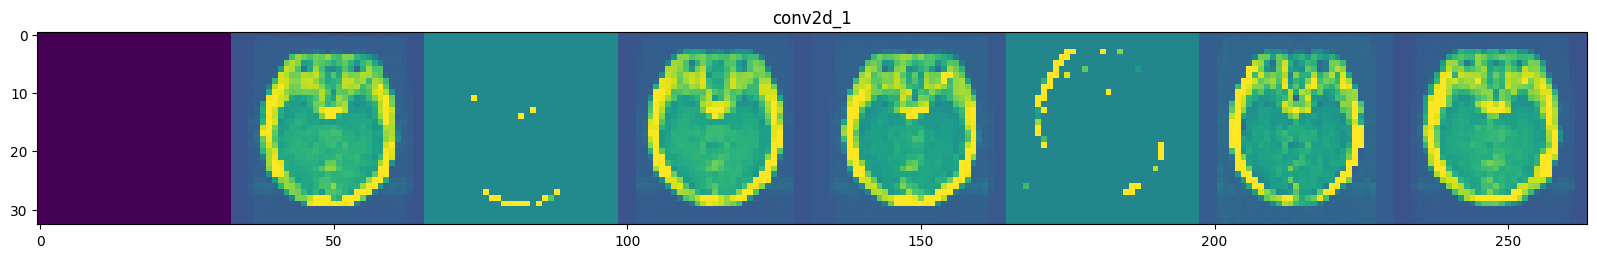

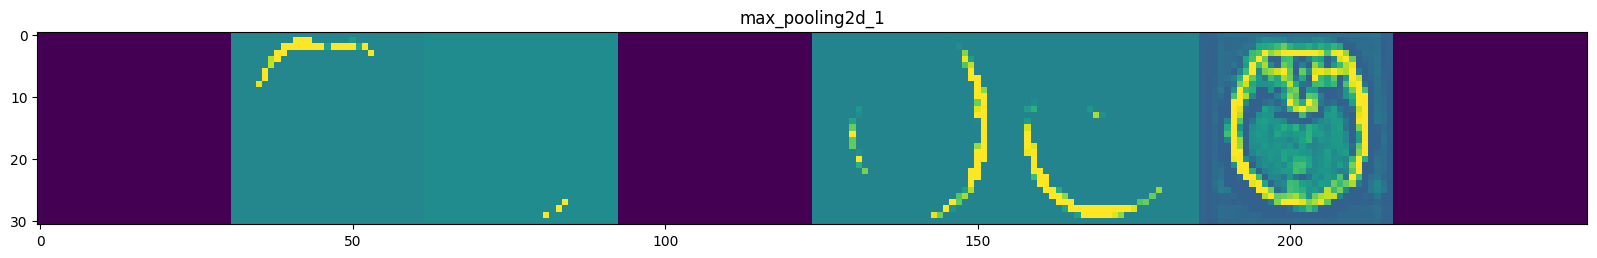

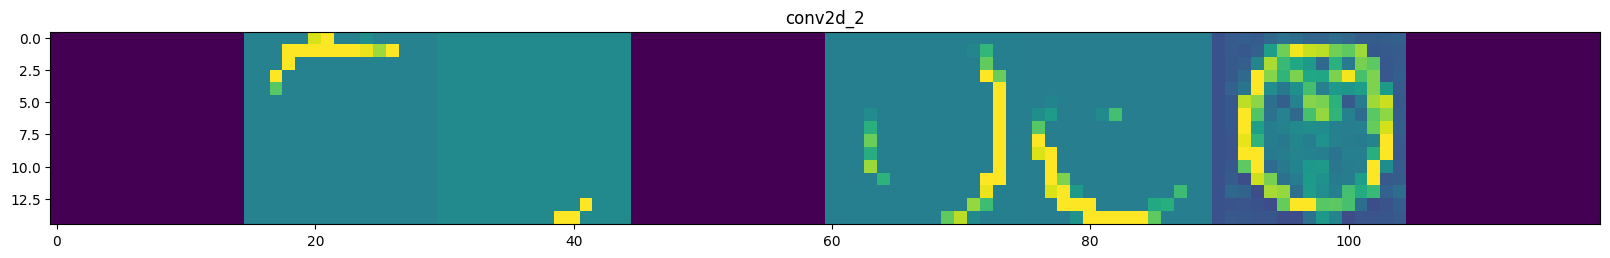

In [20]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img_path= df['Filepaths'][4]
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(512, 512))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [21]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

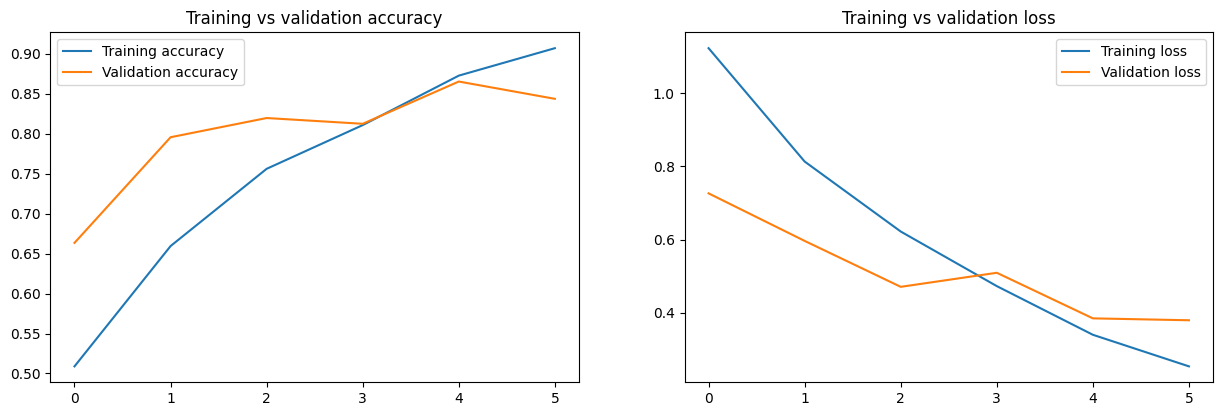

In [22]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()


In [23]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = train_images.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

123/123 [==============================] - 7s 55ms/step
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
[1 3 1 1 1 1 2 3 3 1 1 0 3 0 3 1 1 3 2 2 3 3 1 0 2 0 2 1 1 3 2 0 0 3 3 1 0
 2 3 1 3 1 2 3 3 3 0 3 3 3 3 2 1 1 1 1 1 1 0 3 1 0 2 1 1 2 1 3 3 3 3 1 1 0
 1 2 0 1 3 2 3 0 1 3 1 1 1 0 3 2 3 1 2 1 2 1 1 3 1 2 0 0 0 3 0 3 3 3 1 3 0
 3 1 2 2 1 3 3 3 2 3 3 0 1 1 0 1 0 3 3 1 0 0 1 2 1 3 0 1 2 3 0 0 1 1 3 0 1
 3 0 1 1 1 0 0 1 3 1 1 3 1 1 3 3 1 1 1 3 1 3 2 3 0 3 3 2 2 0 2 3 1 0 1 0 1
 1 1 0 0 0 3 1 3 3 0 3 0 0 3 1 1 2 0 2 3 3 1 1 1 1 0 3 0 0 0 0 3 2 1 1 3 3
 1 0 1 3 2 1 2 2 3 0 3 1 0 1 1 1 1 1 3 1 3 3 1 1 1 1 3 0 3 2 1 1 0 3 1 0 0
 3 1 1 1 3 1 1 3 3 3 3 0 1 3 1 3 1 0 2 1 1 0 1 2 1 1 0 0 1 0 1 1 0 0 3 3 1
 3 1 1 1 2 2 3 1 3 0 1 1 3 0 3 3 3 0 2 1 1 1 2 3 1 2 1 1 3 1 3 1 2 3 2 0 0
 3 1 3 3 0 1 1 1 3 0 1 3 2 0 2 3 3 1 1 2 0 2 0 1 3 3 0 1 2 1 3 0 3 0 0 1 1
 3 3 3 2 2 3 2 3 3 3 1 1 0 3 0 2 2 1 1 0 2 1 1 3 3 2 3 3 3 0 1 3 2 1 0 1 3
 0 1 0 1 1 3 1 2 1 1 0 3 3 3 0 3 2 1 1 

In [24]:
y_pred = [labels[k] for k in pred]
print(classification_report(test_df.Labels, y_pred))
print('--------------------------------')
print(confusion_matrix(test_df.Labels, y_pred))
print('--------------------------------')

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.63      0.76       146
meningioma_tumor       0.70      0.93      0.80       133
        no_tumor       0.90      0.88      0.89        75
 pituitary_tumor       0.92      0.98      0.95       136

        accuracy                           0.85       490
       macro avg       0.87      0.86      0.85       490
    weighted avg       0.87      0.85      0.84       490

--------------------------------
[[ 92  42   7   5]
 [  3 124   0   6]
 [  0   8  66   1]
 [  1   2   0 133]]
--------------------------------


In [25]:
model.evaluate(test_images)[1]

123/123 [==============================] - 6s 45ms/step - loss: 0.4468 - accuracy: 0.8469


0.8469387888908386